In [1]:
# import fred data
import pandas as pd
import datetime

data = pd.read_csv('data/fred-md-sept-2025.csv', parse_dates=['sasdate'])
# parse sasdate column as datetime
# data['sasdate'] = pd.to_datetime(data['sasdate'], format='%d/%m/%Y')
# set index to sasdate column
data = data.set_index(data["sasdate"])

In [2]:
# Read the 'Monthly' sheet from the median_house_price file
import numpy as np


prices = pd.read_excel("data/median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

# FIX: Actually set the index properly
prices = prices.set_index("observation_date")

# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    "data/cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series and set index
cpi = cpi_data.set_index("observation_date")["cpi"]

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

# Calculate real house prices
cpi_100 = cpi / 100  # Convert CPI to index form
real_prices = prices.price / cpi_100  # Now both are properly indexed

log_real_prices = np.log(real_prices)
log_real_prices_diff = log_real_prices.diff().dropna()


observation_date
1963-01-01    30.44
1963-02-01    30.48
1963-03-01    30.51
1963-04-01    30.48
1963-05-01    30.51
Name: cpi, dtype: float64
Rows after filtering: 752


Explained variance ratio: [0.47959578 0.23126449 0.06143117 0.05115898 0.04123336]


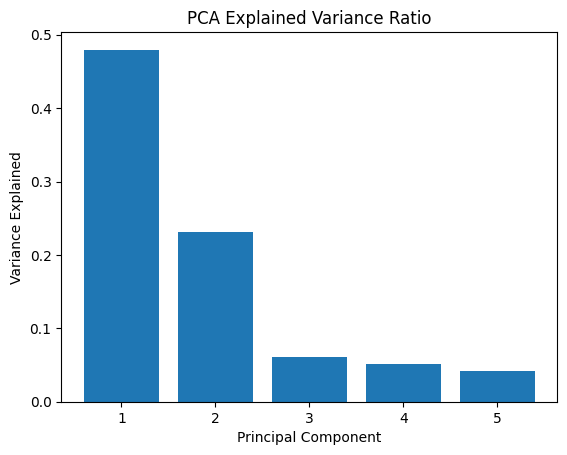

In [3]:
# do a pca on the data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['sasdate']))
pca = PCA(n_components=5)
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns.drop('sasdate'))
data_scaled = data_scaled.dropna()
data = data.loc[data_scaled.index]

log_real_prices_diff = log_real_prices_diff.reindex(data.index).dropna()

data_pca = pca.fit_transform(data_scaled)

# align fred data with log real prices diff


# convert pca result to dataframe
data_pca_df = pd.DataFrame(data_pca, index=data.index, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
# print explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)
# plot explained variance ratio
import matplotlib.pyplot as plt
plt.bar(range(1, 6), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.savefig('data/fred_md_pca_explained_variance.png')
# save pca result to csv
data_pca_df.to_csv('data/fred_md_pca.csv')


In [8]:
# Extract the first 2 principal components
X_PC = data_pca_df[['PC1', 'PC2', 'PC3']]

y_PC = log_real_prices_diff
y_lag_1 = y_PC.shift(-1).dropna()
y_lag_2 = y_PC.shift(-2).dropna()
y_lag_3 = y_PC.shift(-3).dropna()

X_AR = X_PC.loc[y_lag_2.index]
X_AR_final = pd.concat(
    [X_PC, y_lag_1.rename("y_lag_1"), y_lag_2.rename("y_lag_2"), y_lag_3.rename("y_lag_3")],
    axis=1,
    join="inner"
)

y_final = y_PC.loc[X_AR_final.index]

In [9]:
# CHOOSE X AND Y
X = X_PC
y = y_PC

# UNCOMMENT FOR ARX
X = X_AR_final
y = y_final

In [10]:


# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
print("Training Set Performance:")
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

# Display model coefficients
print(f"\nModel Coefficients:")
print(f"PC1: {model.coef_[0]:.4f}")
print(f"PC2: {model.coef_[1]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Training Set Performance:
R² Score: 0.3503
RMSE: 0.0329
MAE: 0.0252

Test Set Performance:
R² Score: 0.2529
RMSE: 0.0342
MAE: 0.0269

Model Coefficients:
PC1: 0.0000
PC2: 0.0005
Intercept: 0.0031


Running Rolling Window Forecast...
Running Expanding Window Forecast...
Running One-Step Forecast...

FORECASTING SCHEMES COMPARISON
          Scheme     RMSE      MAE       R²   MAPE (%)  N_predictions
  Rolling Window 0.032312 0.025159 0.183266 617.902832             50
Expanding Window 0.031832 0.024302 0.207326 597.037375             50
        One-Step 0.031839 0.024228 0.206986 589.898110             50


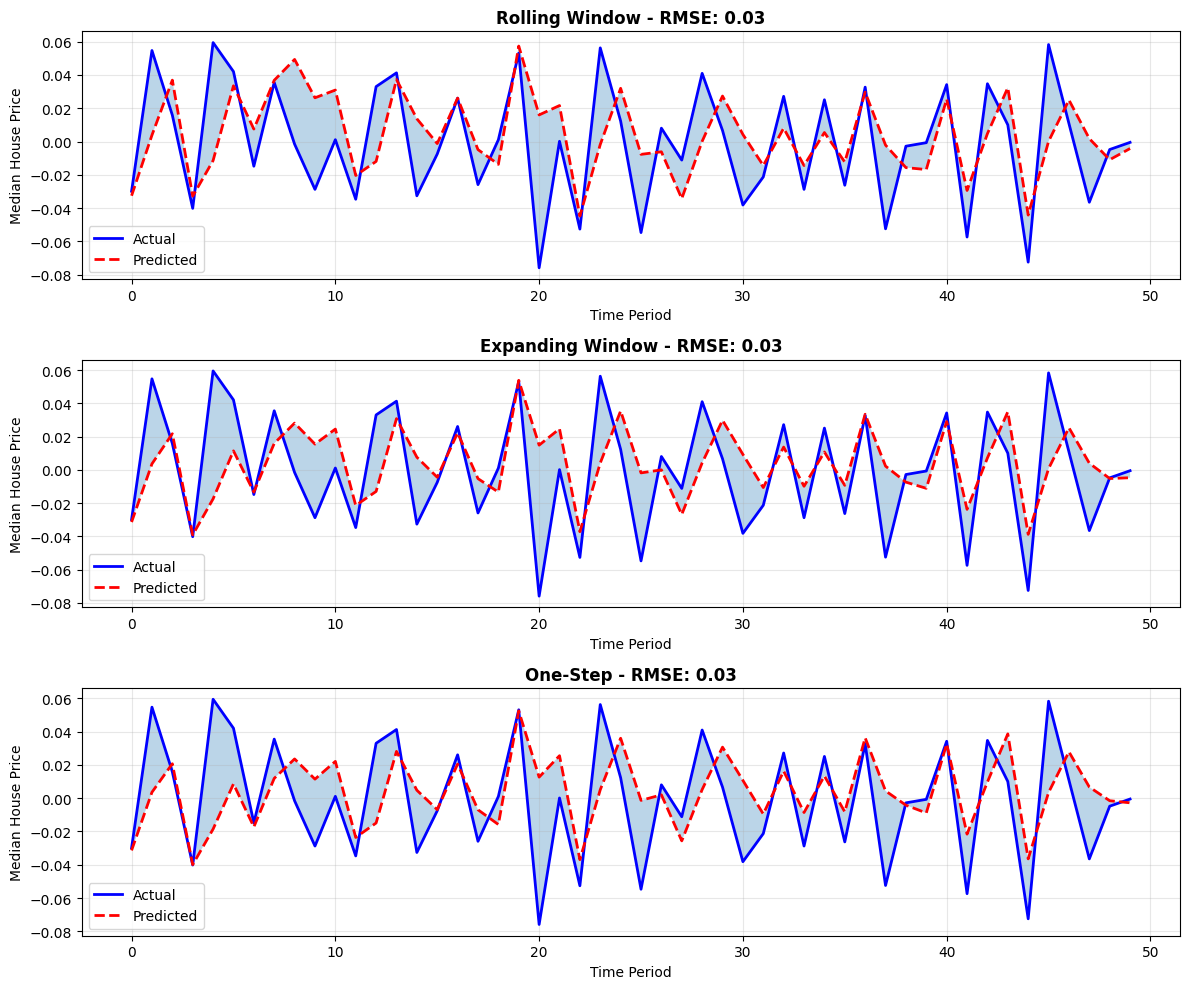

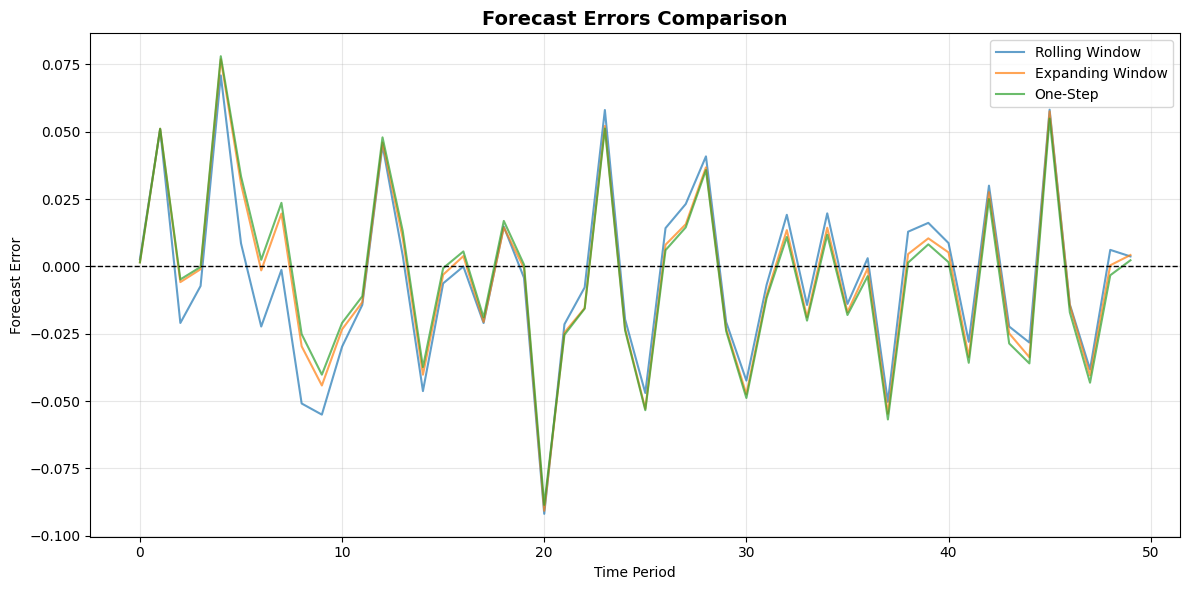


Visualizations saved as 'forecast_comparison.png' and 'forecast_errors.png'


In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have:
# X = data_pca_df[['PC1', 'PC2']]
# y = your target variable (median house price)

def rolling_window_forecast(X, y, window_size, test_size):
    """
    Rolling window: Fixed-size training window that slides forward
    """
    n = len(X)
    train_end = n - test_size
    predictions = []
    actuals = []
    
    for i in range(train_end, n):
        # Define rolling window
        start_idx = max(0, i - window_size)
        end_idx = i
        
        # Train on rolling window
        X_train = X.iloc[start_idx:end_idx]
        y_train = y.iloc[start_idx:end_idx]
        
        # Test on next observation
        X_test = X.iloc[i:i+1]
        y_test = y.iloc[i]
        
        # Fit and predict
        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        
        predictions.append(pred)
        actuals.append(y_test)
    
    return np.array(predictions), np.array(actuals)


def expanding_window_forecast(X, y, initial_train_size, test_size):
    """
    Expanding window: Training set grows with each iteration
    """
    n = len(X)
    train_end = n - test_size
    predictions = []
    actuals = []
    
    for i in range(train_end, n):
        # Expanding window: from start to current point
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]
        
        # Test on next observation
        X_test = X.iloc[i:i+1]
        y_test = y.iloc[i]
        
        # Fit and predict
        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        
        predictions.append(pred)
        actuals.append(y_test)
    
    return np.array(predictions), np.array(actuals)


def one_step_forecast(X, y, train_size):
    """
    One-step ahead: Train once, predict all test observations sequentially
    """
    # Split data
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_test = y.iloc[train_size:]
    
    # Train once
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict all test observations
    predictions = model.predict(X_test)
    actuals = y_test.values
    
    return predictions, actuals


def evaluate_forecast(predictions, actuals, scheme_name):
    """
    Calculate and display forecast metrics
    """
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    results = {
        'Scheme': scheme_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'N_predictions': len(predictions)
    }
    
    return results


# Example usage:
# -----------------
# Set parameters
window_size = 100  # for rolling window
test_size = 50     # number of observations to forecast
initial_train_size = len(X) - test_size  # for expanding and one-step

# Run all three schemes
print("Running Rolling Window Forecast...")
rolling_pred, rolling_actual = rolling_window_forecast(X, y, window_size, test_size)

print("Running Expanding Window Forecast...")
expanding_pred, expanding_actual = expanding_window_forecast(X, y, initial_train_size, test_size)

print("Running One-Step Forecast...")
onestep_pred, onestep_actual = one_step_forecast(X, y, initial_train_size)

# Evaluate all schemes
results = []
results.append(evaluate_forecast(rolling_pred, rolling_actual, 'Rolling Window'))
results.append(evaluate_forecast(expanding_pred, expanding_actual, 'Expanding Window'))
results.append(evaluate_forecast(onestep_pred, onestep_actual, 'One-Step'))

# Create comparison table
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("FORECASTING SCHEMES COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

schemes = [
    ('Rolling Window', rolling_pred, rolling_actual),
    ('Expanding Window', expanding_pred, expanding_actual),
    ('One-Step', onestep_pred, onestep_actual)
]

for idx, (name, pred, actual) in enumerate(schemes):
    ax = axes[idx]
    time_index = range(len(pred))
    
    ax.plot(time_index, actual, label='Actual', color='blue', linewidth=2)
    ax.plot(time_index, pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    ax.fill_between(time_index, actual, pred, alpha=0.3)
    
    ax.set_title(f'{name} - RMSE: {np.sqrt(mean_squared_error(actual, pred)):.2f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Median House Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Forecast errors comparison
fig, ax = plt.subplots(figsize=(12, 6))

errors_rolling = rolling_actual - rolling_pred
errors_expanding = expanding_actual - expanding_pred
errors_onestep = onestep_actual - onestep_pred

time_index = range(len(errors_rolling))

ax.plot(time_index, errors_rolling, label='Rolling Window', alpha=0.7)
ax.plot(time_index, errors_expanding, label='Expanding Window', alpha=0.7)
ax.plot(time_index, errors_onestep, label='One-Step', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_title('Forecast Errors Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Forecast Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualizations saved as 'forecast_comparison.png' and 'forecast_errors.png'")